In [3]:
#liberar memoria de la GPU  
#from numba import cuda
#cuda.select_device(0)
##cuda.select_device(1)
#cuda.close()
#from tensorflow.keras import backend as K
#K.clear_session()
#liberar memoria de la RAM
#import gc
#gc.collect()


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2023-11-30 11:49:21.273311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 11:49:24.462274: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-30 11:49:24.462397: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-30 11:49:24.462405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Num GPUs Available:  2


2023-11-30 11:49:26.779588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 11:49:26.783071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 11:49:27.168549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 11:49:27.171383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 11:49:27.174082: I tensorflow/compiler/xla/stream_executo

## Librerias y cargar dataset

In [2]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
#from google.colab import files
import zipfile

2023-12-05 13:19:22.203546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 13:19:22.881380: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-05 13:19:22.881429: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-12-05 13:19:22.881434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [6]:
#uploaded = files.upload()

Descomprimir dataset

In [7]:
#with zipfile.ZipFile("DroughtDatasetMask.zip", 'r') as data:
#    data.extractall("DroughtDatasetMask/dataset")

## Funciones

In [3]:
def create_shifted_frames_2(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, data.shape[1]-1, :, :]
    return x, y

#Toma todos los colores existentes en la imagen
def get_colors(image):
  aux = []
  band = True
  for i in image:
    for j in i:

      for k in aux:
        if j.tolist() == k:
          band = False
          break
      if band:
        aux.append(j.tolist())
      band = True
  return np.array(aux)

def balance_img_categories(img, palette, balancer):
  #palette = np.sort(palette)
  rows = len(img)
  cols = len(img[0])
  for i in range(rows):
    for j in range(cols):
      pos = np.where(palette == img[i,j])[0][0]
      img[i,j] = balancer[pos]
  return img


#Función para dada una paleta solo tomar los colores de esa paleta en la imagen
def quantizetopalette(silf, palette, dither=False, mode="P"):
  """Convert an RGB or L mode image to use a given P image's palette."""
  silf.load()
  palette.load()
  im = silf.im.convert(mode, 0, palette.im)
  # the 0 above means turn OFF dithering making solid colors
  return silf._new(im)

#Realiza las operaciones necesarias para obtener una imagen RGB por una paleta de colores
def rgb_quantized(img, palette):
  rows, cols = len(img), len(img[0])
  total_vals = 1
  for i in palette.shape:
    total_vals *= i
  palettedata = palette.reshape(total_vals).tolist()
  palImage = Image.new('P', (rows, cols))
  palImage.putpalette(palettedata*32)
  oldImage = Image.fromarray(img).convert("RGB")
  newImage = quantizetopalette(oldImage,palImage)
  res_image = np.asarray(newImage.convert("RGB"))
  return res_image

def gray_quantized(img, palette):
  rows, cols = len(img), len(img[0])
  total_vals = 1
  for i in palette.shape:
    total_vals *= i
  palettedata = palette.reshape(total_vals).tolist()
  palImage = Image.new('L', (rows, cols))
  palImage.putpalette(palettedata*32)
  oldImage = Image.fromarray(img, 'L')
  newImage = quantizetopalette(oldImage,palImage, mode="L")
  res_image = np.asarray(newImage)
  return res_image

def recolor_greys_image(data, palette):
    rows, cols = len(data), len(data[0])
    aux = np.zeros((rows, cols), dtype=np.uint64)
    for i in range(rows):
        for j in range(cols):
            aux[i,j] = min(palette, key= lambda x:abs(x-data[i,j]))
    return aux


def agroup_window(data, window):
    new_data = [data[i:window+i] for i in range(len(data)-window+1)]
    return np.array(new_data)


def add_last(data, new_vals):
    print(f"data: {data.shape} y new_val: {new_vals.shape}")
    x_test_new = data[:,1:]
    print(f"x_test_new: {x_test_new.shape}")

    l = []
    for i in range(len(x_test_new)):
        l.append(np.append(x_test_new[i], new_vals[i]))
    x_test_new = np.array(l).reshape(data.shape[:])
    print("CX", x_test_new.shape)
    return x_test_new

def add_lastNew(data, new_val):
    print(f"data: {data.shape} y new_val: {new_val.shape}")
    x_test_new = data[:,1:,...]  # Omite el primer paso de tiempo
    print(f"x_test_new: {x_test_new.shape}")

    # Asumiendo que new_val es una única predicción que se debe añadir a cada paso de tiempo en x_test_new
    new_val = new_val.squeeze(axis=0)  # Elimina la dimensión del batch, si es necesario

    print(new_val.shape)
    # Añadir new_val a cada elemento en x_test_new
    x_test_new = np.concatenate((x_test_new, np.expand_dims(new_val, axis=1)), axis=1)

    print("CX", x_test_new.shape)
    return x_test_new


    #Crea cubos con su propia información de tamaño h
def get_cubes(data, h):
    new_data = []
    for i in range(0, len(data)-h):
        new_data.append(data[i:i+h])
    new_data = np.array(new_data)
    print(new_data.shape)
    return new_data

## Codigo

Variables iniciales para correr el codigo

In [3]:
rows = 61
cols = 180
channels = 1
window = 5
categories = [0, 35, 70, 119, 177, 220, 255] 
horizon = 4
parte = "Part0_1"

De la carpeta con las imagenes pasarlo a un arreglo npy

(1240, 61, 180)


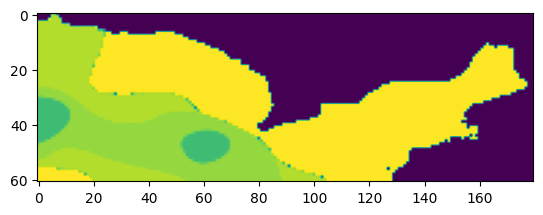

In [9]:
#cargar npy de parte y mostrar primera imagen 
data = np.load(f"DroughtDatasetMask/NPY61_180Part0_1/DroughtDatasetMask_Part0_1.npy")
print(data.shape)
plt.imshow(data[0])
plt.show()

# superior derecha

img recortada (61, 190, 3)


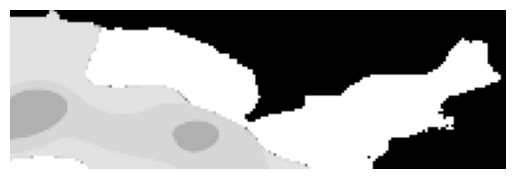

In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Asumamos que tienes la imagen cargada en el notebook como un array de numpy
# Si necesitas cargarla desde un archivo, puedes usar cv2.imread('ruta_al_archivo')
imagen_original = cv2.imread('DroughtDatasetMask/dataset/DroughtDatasetMask/2000-01-04.png')

# Dimensiones deseadas para el recorte
altura_deseada = 61
ancho_deseado = 190

# Calcular el punto de inicio del recorte
inicio_x = imagen_original.shape[1] - ancho_deseado
inicio_y = 0  # Desde la parte superior

# Realizar el recorte
imagen_recortada = imagen_original[inicio_y:inicio_y + altura_deseada, inicio_x:inicio_x + ancho_deseado]

print("img recortada", imagen_recortada.shape)
# Mostrar la imagen recortada
plt.imshow(cv2.cvtColor(imagen_recortada, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB para mostrar correctamente
plt.axis('off')  # No mostrar los ejes
plt.show()



recorte de la img

In [33]:
import cv2
import os

# Set the path to the folder containing the images
folder_path = 'DroughtDatasetMask/dataset/DroughtDatasetMask'

# Get a list of all the image file names in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
images = []  # List to store the images
# Loop through the image files
for file in image_files:
    # Load the image using OpenCV
    image_path = os.path.join(folder_path, file)
    imagen_original = cv2.imread(image_path)

    # Dimensiones deseadas para el recorte
    altura_deseada = 61
    ancho_deseado = 190

    # Calcular el punto de inicio del recorte
    inicio_x = imagen_original.shape[1] - ancho_deseado
    inicio_y = 0  # Desde la parte superior

    # Realizar el recorte
    imagen_recortada = imagen_original[inicio_y:inicio_y + altura_deseada, inicio_x:inicio_x + ancho_deseado]

    # añadir la imagen a una carpeta
    cv2.imwrite(f'DroughtDatasetMask/dataset/BordesNuevos/61_180Part0_1/dataset/{file}', imagen_recortada)
    

creacion del npy

In [9]:
import cv2
import os
import numpy as np

# Set the path to the folder containing the images
folder_path = 'DroughtDatasetMask/dataset/BordesNuevos/61_180Part0_1/dataset'

# Get a sorted list of all the image file names in the folder
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')])

# Create an empty list to hold the images
images = []

# Loop through the sorted image files and add each image to the list
for file in image_files:
    # Load the image using OpenCV
    image_path = os.path.join(folder_path, file)
    image = cv2.imread(image_path)
    #print(file)
    #pasar a escala de grises
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print(image.shape)
    # Add the image to the list
    images.append(image)

# Convert the list of images to a numpy array
images_array = np.array(images)

# Print the shape of the numpy array
print(images_array.shape)

# Save the numpy array to a file
np.save('DroughtDatasetMask/dataset/BordesNuevos/61_180Part0_1/DroughtDatasetMaskBordesNuevos0_1v2.npy', images_array)


(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)


(1240, 61, 190, 3)


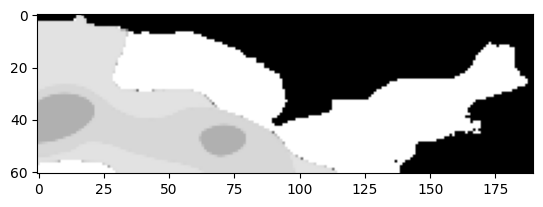

In [50]:
#cargar npy de parte y mostrar primera imagen
data = np.load(f"DroughtDatasetMask/dataset/BordesNuevos/61_180Part0_1/DroughtDatasetMaskBordesNuevosv20_1.npy")
print(data.shape)
plt.imshow(data[0])
plt.show()


# inferior izquierda

(1240, 61, 180)


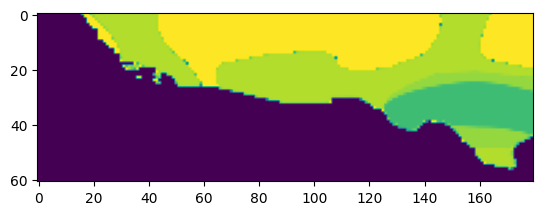

In [23]:
#cargar npy de parte y mostrar primera imagen 
data = np.load(f"DroughtDatasetMask/NPY61_180Part1_0/DroughtDatasetMask_Part1_0.npy")
print(data.shape)
plt.imshow(data[0])
plt.show()

inicio x 0
inicio y 51
img recortada (71, 180, 3)


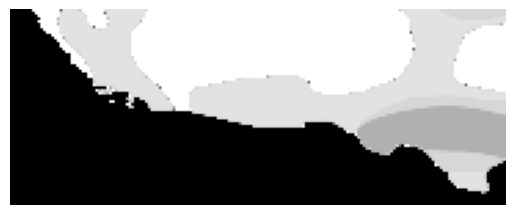

In [22]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Asumamos que tienes la imagen cargada en el notebook como un array de numpy
# Si necesitas cargarla desde un archivo, puedes usar cv2.imread('ruta_al_archivo')
imagen_original = cv2.imread('DroughtDatasetMask/dataset/DroughtDatasetMask/2000-01-04.png')

# Dimensiones deseadas para el recorte
altura_deseada = 71
ancho_deseado = 180

# Calcular el punto de inicio del recorte (desde la parte inferior izquierda)
inicio_x = 0
inicio_y = imagen_original.shape[0] - altura_deseada

print("inicio x", inicio_x)
print("inicio y", inicio_y)
# Realizar el recorte
imagen_recortada = imagen_original[inicio_y:inicio_y + altura_deseada, inicio_x:inicio_x + ancho_deseado]

print("img recortada", imagen_recortada.shape)
# Mostrar la imagen recortada
plt.imshow(cv2.cvtColor(imagen_recortada, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB para mostrar correctamente
plt.axis('off')  # No mostrar los ejes
plt.show()

recorte de la img

In [52]:
# Set the path to the folder containing the images
folder_path = 'DroughtDatasetMask/dataset/DroughtDatasetMask'

# Get a list of all the image file names in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
images = []  # List to store the images
# Loop through the image files
for file in image_files:
    # Load the image using OpenCV
    image_path = os.path.join(folder_path, file)
    imagen_original = cv2.imread(image_path)
    # Dimensiones deseadas para el recorte
    altura_deseada = 71
    ancho_deseado = 180

    # Calcular el punto de inicio del recorte (desde la parte inferior izquierda)
    inicio_x = 0
    inicio_y = imagen_original.shape[0] - altura_deseada

    # Realizar el recorte
    imagen_recortada = imagen_original[inicio_y:inicio_y + altura_deseada, inicio_x:inicio_x + ancho_deseado]


    # añadir la imagen a una carpeta
    cv2.imwrite(f'DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_0/dataset/{file}', imagen_recortada)

creacion del npy

In [8]:
# Set the path to the folder containing the images
folder_path = 'DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_0/dataset'

# Get a sorted list of all the image file names in the folder
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')])

# Create an empty list to hold the images
images = []

# Loop through the sorted image files and add each image to the list
for file in image_files:
    # Load the image using OpenCV
    image_path = os.path.join(folder_path, file)
    image = cv2.imread(image_path)
    #print(file)
    #pasar a escala de grises
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print(image.shape)
    # Add the image to the list
    images.append(image)

# Convert the list of images to a numpy array
images_array = np.array(images)

# Print the shape of the numpy array
print(images_array.shape)

# Save the numpy array to a file
np.save('DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_0/DroughtDatasetMaskBordesNuevos1_0v2.npy', images_array)

(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)


(1240, 71, 180, 3)


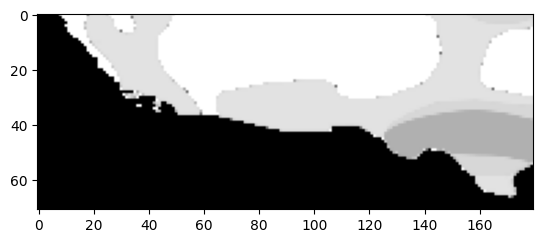

In [57]:
#cargar npy de parte y mostrar primera imagen 
data1_0 = np.load(f"DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_0/DroughtDatasetMaskBordesNuevos1_0.npy")
print(data1_0.shape)
plt.imshow(data1_0[0])
plt.show()

# Inferior derecha

(1240, 61, 180)


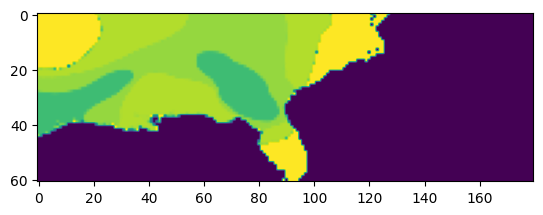

In [5]:
#cargar npy de parte y mostrar primera imagen 
data = np.load(f"DroughtDatasetMask/NPY61_180Part1_1/DroughtDatasetMask_Part1_1.npy")
print(data.shape)
plt.imshow(data[0])
plt.show()

img recortada (71, 190, 3)


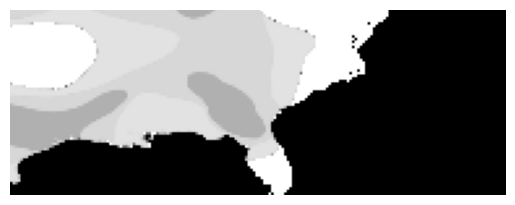

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Asumamos que tienes la imagen cargada en el notebook como un array de numpy
# Si necesitas cargarla desde un archivo, puedes usar cv2.imread('ruta_al_archivo')
imagen_original = cv2.imread('DroughtDatasetMask/dataset/DroughtDatasetMask/2000-01-04.png')

# Dimensiones deseadas para el recorte
altura_deseada = 71
ancho_deseado = 190

# Calcular el punto de inicio del recorte (desde la parte inferior izquierda)
inicio_x = imagen_original.shape[1] - ancho_deseado
inicio_y = imagen_original.shape[0] - altura_deseada

# Realizar el recorte
imagen_recortada = imagen_original[inicio_y:inicio_y + altura_deseada, inicio_x:inicio_x + ancho_deseado]

print("img recortada", imagen_recortada.shape)
# Mostrar la imagen recortada
plt.imshow(cv2.cvtColor(imagen_recortada, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB para mostrar correctamente
plt.axis('off')  # No mostrar los ejes
plt.show()

recorte de la img

In [53]:
# Set the path to the folder containing the images
folder_path = 'DroughtDatasetMask/dataset/DroughtDatasetMask'

# Get a list of all the image file names in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
images = []  # List to store the images
# Loop through the image files
for file in image_files:
    # Load the image using OpenCV
    image_path = os.path.join(folder_path, file)
    imagen_original = cv2.imread(image_path)

    # Dimensiones deseadas para el recorte
    altura_deseada = 71
    ancho_deseado = 190

    # Calcular el punto de inicio del recorte (desde la parte inferior izquierda)
    inicio_x = imagen_original.shape[1] - ancho_deseado
    inicio_y = imagen_original.shape[0] - altura_deseada

    # Realizar el recorte
    imagen_recortada = imagen_original[inicio_y:inicio_y + altura_deseada, inicio_x:inicio_x + ancho_deseado]


    # añadir la imagen a una carpeta
    cv2.imwrite(f'DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_1/dataset/{file}', imagen_recortada)

creacion de numpy inferior derecha

In [7]:
# Set the path to the folder containing the images
folder_path = 'DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_1/dataset'

# Get a sorted list of all the image file names in the folder
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')])

# Create an empty list to hold the images
images = []

# Loop through the sorted image files and add each image to the list
for file in image_files:
    # Load the image using OpenCV
    image_path = os.path.join(folder_path, file)
    image = cv2.imread(image_path)
    #print(file)
    #pasar a escala de grises
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print(image.shape)
    # Add the image to the list
    images.append(image)

# Convert the list of images to a numpy array
images_array = np.array(images)

# Print the shape of the numpy array
print(images_array.shape)

# Save the numpy array to a file
np.save('DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_1/DroughtDatasetMaskBordesNuevos1_1v2.npy', images_array)

(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)


visualizar data 0

(1240, 71, 190, 3)


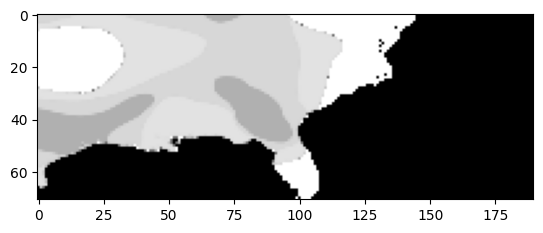

In [59]:
#cargar npy de parte y mostrar primera imagen 
data1_1 = np.load(f"DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_1/DroughtDatasetMaskBordesNuevos1_1.npy")
print(data1_1.shape)
plt.imshow(data1_1[0])
plt.show()

# fin

In [60]:
x = np.load(f"DroughtDatasetMask/NPY61_180Part0_1/DroughtDatasetMask_Part0_1.npy")

Displaying frames for example 307


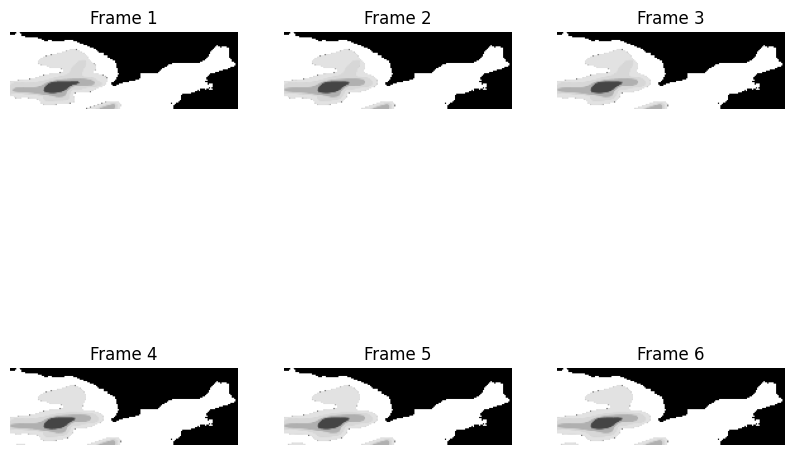

In [63]:
#Mostrar imágenes
fig, axes = plt.subplots(2, 3, figsize= (10,8))

data_choise = np.random.choice(range(len(x)), size= 1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(x[data_choise+idx]), cmap='gray')
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
print("Displaying frames for example {}".format(data_choise))
plt.show()

Displaying frames for example 307


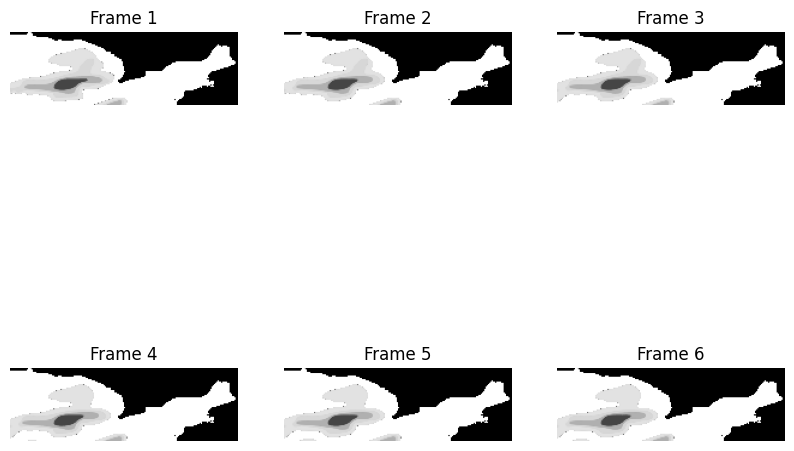

In [64]:
#Mostrar imágenes
fig, axes = plt.subplots(2, 3, figsize= (10,8))
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(data[data_choise+idx]), cmap='gray')
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
print("Displaying frames for example {}".format(data_choise))
plt.show()

# Nuevo codigo de recorte de los bordes

In [ ]:
import cv2
import os
import numpy as np

def recortar_y_guardar(imagen, num_divisiones, carpeta_destino):
    altura, ancho = imagen.shape[:2]
    altura_recorte = altura // num_divisiones
    ancho_recorte = ancho // num_divisiones

    for i in range(num_divisiones):
        for j in range(num_divisiones):
            inicio_y = i * altura_recorte
            inicio_x = j * ancho_recorte
            fin_y = inicio_y + altura_recorte
            fin_x = inicio_x + ancho_recorte

            imagen_recortada = imagen[inicio_y:fin_y, inicio_x:fin_x]

            # Aplicar margen si no es la primera imagen
            if not (i == 0 and j == 0):
                imagen_recortada = cv2.copyMakeBorder(imagen_recortada, 10, 10, 10, 10, cv2.BORDER_CONSTANT)

            nombre_archivo = f"{carpeta_destino}/recorte_{i}_{j}.jpg"
            cv2.imwrite(nombre_archivo, imagen_recortada)

# Código para procesar las imágenes
folder_path = 'ruta/a/imagenes'
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

for file in image_files:
    image_path = os.path.join(folder_path, file)
    imagen = cv2.imread(image_path)
    # Aplicar el recorte y guardar para cada tamaño
    for num_divisiones in [2, 3, 4]:
        carpeta_destino = f"ruta/a/imagenes_recortadas/{num_divisiones}x{num_divisiones}"
        os.makedirs(carpeta_destino, exist_ok=True)
        recortar_y_guardar(imagen, num_divisiones, carpeta_destino)
